In [8]:
import numpy as np
import scipy.special as sc

from scipy.integrate import odeint,solve_ivp
import matplotlib.pyplot as plt
import pandas as pd
#from scipy.optimize import minimize
from scipy import interpolate
from scipy.optimize import least_squares

### 2. Credible interval (PMLS2, problem 7.5). (10 points)

#### Q2a

In [192]:
# regularized incomplete beta function 
# scipy.special.betainc(a, b, x, out=None) = <ufunc 'betainc'>
#sc.betainc(0.2, 3.5, 1.0)

# 301 heads in 600 flips
l=301
M=600
a=l+1
b=M-l+1
xi_star=301/600
delta=0.0335

sc.betainc(a, b, xi_star+delta) - sc.betainc(a, b, xi_star-delta)

0.9000439048752535

In [193]:
print(sc.btdtri(a, b, 0.05))

0.46816231522992624


In [196]:
print(sc.betaincinv(a, b,0.05), sc.betaincinv(a, b,0.95))

0.46816231522992624 0.5351536633592071


In [195]:
print(xi_star-delta, xi_star+delta)

0.46816666666666673 0.5351666666666667


#### Q2b

In [197]:
l=6
M=25
a=l+1
b=M-l+1
xi_star=l/M
delta=0.138

sc.betainc(a, b, xi_star+delta) - sc.betainc(a, b, xi_star-delta)

0.9006536943823586

In [199]:
print(xi_star, xi_star-delta, xi_star+delta)
print(sc.betaincinv(a, b,0.05), sc.betaincinv(a, b,0.95))

0.24 0.10199999999999998 0.378
0.13377412564451904 0.40535383443116624


#### Q2c

In [200]:
# control
l=4
M=25
a=l+1
b=M-l+1
xi_star=l/M
delta=0.126

sc.betainc(a, b, xi_star+delta) - sc.betainc(a, b, xi_star-delta)

0.9016623867189003

In [201]:
print(xi_star, xi_star-delta, xi_star+delta)
print(sc.betaincinv(a, b,0.05), sc.betaincinv(a, b,0.95))

0.16 0.034 0.28600000000000003
0.07898571028519465 0.31824178925036417


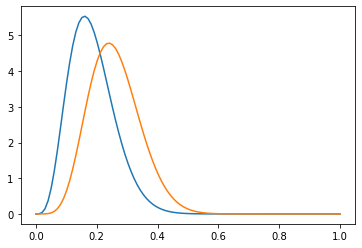

In [ ]:
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt


a1, b1 = 5, 22
rv1 = beta(a1, b1)

a2, b2 = 7, 20
rv2 = beta(a2, b2)

x = np.linspace(0, 1, 100)
plt.plot(x, rv1.pdf(x))
plt.plot(x, rv2.pdf(x))

#### Q4b
(b) Write a Python function to simulate the model using numerical integration (scipy's odeint or solve_ivp are good choices). Plot the results you obtain with the values of the remaining parameters taken as (b,d,p) = (1.0e-7, 1, 100). You should make two plots, one showing each species as a function of time and another showing the viral load, which is defined as the log10 of the number of virus particles. This is the standard way that viral kinetic data is displayed and you should use this form for the remaining plots. 

In [134]:
def viral_kinetics_model(y, t, b, d, p):
    S, I, V, g = y[0], y[1], y[2], 15
    # the differential equations that define the dynamics of the model
    dSdt = -b * S * V
    dVdt = p * I - b * S * V - g * V
    dIdt = b * S * V - d * I
    return [dSdt, dIdt, dVdt]

In [135]:
# parameters
b, d, p = 1e-7, 1, 100

# we will hold the rate constant g fixed at 15/day
g = 15
# the initial size of the susceptible cell population, S0, to be 10^7
S0 = 10**7
# the initial number of infected cells, I0, to be 1
I0 = 1
# the initial number of viral particles, V0, to be pI0/g.
V0 = p*I0/g

# store all values for initial condition
y0 = [S0, I0, V0]

# time points
t = np.linspace(0,20,100)


#viral_kinetics_model(y0, t, b, d, p, g)

# solve ODE
y_out = odeint(viral_kinetics_model, y0, t, args=(b, d, p,))

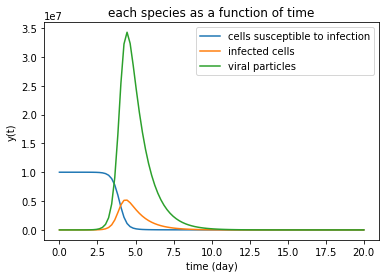

In [136]:
# plot results: each species as a function of time
plt.plot(t,y_out)

plt.title('each species as a function of time')
plt.legend(['cells susceptible to infection', 'infected cells', 'viral particles'])
plt.xlabel('time (day)')
plt.ylabel('y(t)')
plt.show()

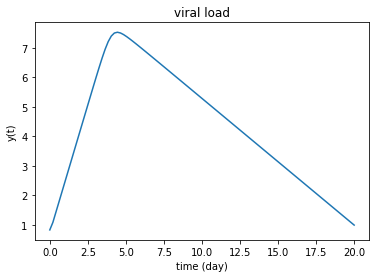

In [137]:
# plot results: viral load
# viral load = log10 of the number of virus particles
plt.plot(t, np.log10(y_out[:,2]))

plt.title('viral load')
plt.xlabel('time (day)')
plt.ylabel('y(t)')
plt.show()

#### Q4c
(c) Define functions to compute the peak viral load (Vmax) and the time post infection at which peak load occurs (tmax). Make plots showing the effect on both Vmax and tmax of varying each of the three parameters (b,d,p) about a five-fold range up and down varying one parameter at a time. For example vary b over the range 2e-8 to 5e-7. Which parameters have the strongest effect on each quantity? [Hint: It may help to use interpolation to determine the value of tmax from the timecourses you compute so that it varies smoothly as each parameter is changed.]

In [138]:
# Define functions to compute the peak viral load (Vmax) 
# and the time post infection at which peak load occurs (tmax)
def max_values(V, t):
    i_max = np.argmax(V)
    return V[i_max], t[i_max]

In [141]:
# varying each parameter about a five-fold range up and down, one parameter at a time
# vary b over the range 2e-8 to 5e-7
b_var = np.linspace(2e-8, 5e-7, 100)
# vary d over the range 0.26, 6.5
d_var = np.linspace(0.22, 0.22*25, 100)
# vary p over the range 10, 250
p_var = np.linspace(23, 23*25, 100)

# row: b,d,p; col: varying values
Vmax_arr = np.empty(shape=(100, 3))
tmax_arr = np.empty(shape=(100, 3))

i = 0
while i < 100:
    y_out_b = odeint(viral_kinetics_model, y0, t, args=(b_var[i], d, p,))
    y_out_d = odeint(viral_kinetics_model, y0, t, args=(b, d_var[i], p,))
    y_out_p = odeint(viral_kinetics_model, y0, t, args=(b, d, p_var[i],))
    V_b = interpolate.interp1d(t, y_out_b[:,2], kind = 'cubic')(t)
    V_d = interpolate.interp1d(t, y_out_d[:,2], kind = 'cubic')(t)
    V_p = interpolate.interp1d(t, y_out_p[:,2], kind = 'cubic')(t)
    V_max_b, t_max_b = max_values(np.log10(V_b), t)
    V_max_d, t_max_d = max_values(np.log10(V_d), t)
    V_max_p, t_max_p = max_values(np.log10(V_p), t)
    Vmax_arr[i,:] = [V_max_b, V_max_d, V_max_p]
    tmax_arr[i,:] = [t_max_b, t_max_d, t_max_p]
    i += 1

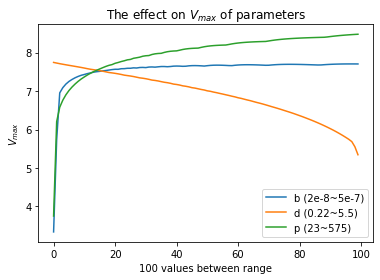

In [142]:
# The effect on Vmax of parameters
plt.plot(Vmax_arr)

plt.title('The effect on $V_{max}$ of parameters')
plt.legend(['b (2e-8~5e-7)', 'd (0.22~5.5)', 'p (23~575)'])
plt.xlabel('100 values between range')
plt.ylabel('$V_{max}$')
plt.show()

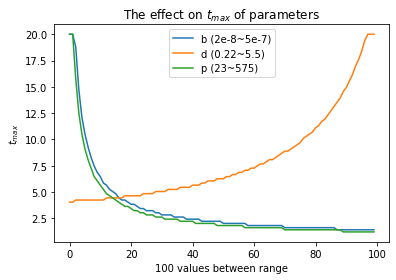

In [143]:
# The effect on tmax of parameters
plt.plot(tmax_arr)

plt.title('The effect on $t_{max}$ of parameters')
plt.legend(['b (2e-8~5e-7)', 'd (0.22~5.5)', 'p (23~575)'])
plt.xlabel('100 values between range')
plt.ylabel('$t_{max}$')
plt.show()

#### Q4d
(d) The sensitivity coefficients are often used to characterize the sensitivities of a model's properties to changes in parameters. These are scaled derivatives that are defined as , where  is the property of interest (here,  or ) and the is the parameter of interest. These are measures of local sensitivity that are computed at a single point the parameter space. Report the sensitivity coefficients for  and  for the model  at (1.0e-7, 1, 100).

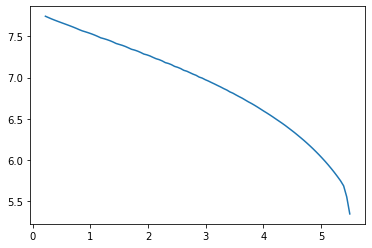

In [157]:
plt.plot(d_var, Vmax_arr[:,1])

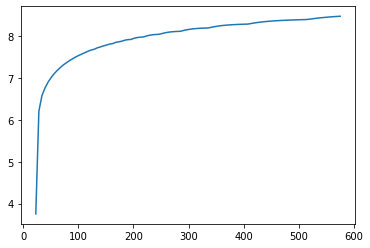

In [155]:
plt.plot(p_var, Vmax_arr[:,2])

In [145]:
b, d, p = 1e-7, 1, 100

y_out = odeint(viral_kinetics_model, y0, t, args=(b, d, p,))
V_max, t_max = max_values(np.log10(y_out[:,2]), t)
b/V_max, d/V_max, p/V_max, b/t_max, d/t_max, p/t_max

(1.3271797319562459e-08,
 0.1327179731956246,
 13.27179731956246,
 2.2499999999999996e-08,
 0.22499999999999998,
 22.5)

In [150]:
# Vmax_arr: V_max_b, V_max_d, V_max_p
# tmax_arr

# b
de_Vmax_b = interpolate.InterpolatedUnivariateSpline(b_var, Vmax_arr[:,0]).derivative()
de_tmax_b = interpolate.InterpolatedUnivariateSpline(b_var, tmax_arr[:,0]).derivative()

S_Vmax_b = (b/V_max)*de_Vmax_b(b)
S_tmax_b = (b/t_max)*de_tmax_b(b)

# d
de_Vmax_d = interpolate.InterpolatedUnivariateSpline(d_var, Vmax_arr[:,1]).derivative()
de_tmax_d = interpolate.InterpolatedUnivariateSpline(d_var, tmax_arr[:,1]).derivative()

S_Vmax_d = (d/V_max)*de_Vmax_d(d)
S_tmax_d = (d/t_max)*de_tmax_d(d)

# p
de_Vmax_p = interpolate.InterpolatedUnivariateSpline(p_var, Vmax_arr[:,2]).derivative()
de_tmax_p = interpolate.InterpolatedUnivariateSpline(p_var, tmax_arr[:,2]).derivative()

S_Vmax_p = (p/V_max)*de_Vmax_p(p)
S_tmax_p = (p/t_max)*de_tmax_p(p)


print("b:", S_Vmax_b, S_tmax_b)
print("d:", S_Vmax_d, S_tmax_d)
print("p:", S_Vmax_p, S_tmax_p)

b: 0.022164091199234456 -0.9378177809679603
d: -0.03276733843137881 -0.011536799876461877
p: 0.08207005860466135 -0.8544100492746549


1670014.354024396
1e-07 7.534774499050048 1670014.291626114


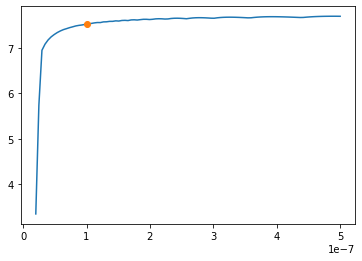

In [179]:
fit_Vmax_b = interpolate.InterpolatedUnivariateSpline(b_var, Vmax_arr[:,0])
plt.plot(b_var, Vmax_arr[:,0])
plt.plot(b, fit_Vmax_b(b),'o')

print((fit_Vmax_b(1e-7*(1+1e-8)) - fit_Vmax_b(1e-7*(1-1e-8)))/(1e-7*(1+1e-8) - 1e-7*(1-1e-8)))
print(b, V_max, de_Vmax_b(b))

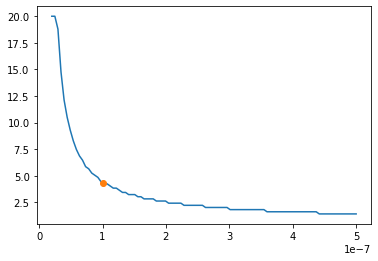

In [180]:
fit_tmax_b = interpolate.InterpolatedUnivariateSpline(b_var, tmax_arr[:,0])
plt.plot(b_var, tmax_arr[:,0])
plt.plot(b, fit_tmax_b(b),'o')


7.534768208147579 7.534774499050048


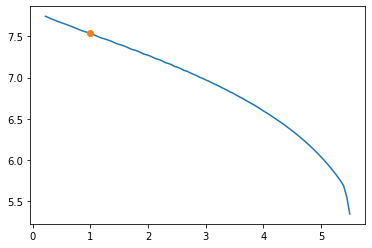

In [164]:
fit_Vmax_d = interpolate.InterpolatedUnivariateSpline(d_var, Vmax_arr[:,1])
plt.plot(d_var, Vmax_arr[:,1])
plt.plot(d, fit_Vmax_d(d),'o')
print(fit_Vmax_d(d), V_max)

4.444049440012946 7.534774499050048
-0.05127466611760835


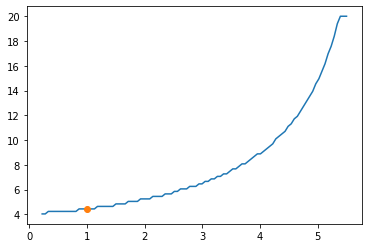

In [182]:
fit_tmax_d = interpolate.InterpolatedUnivariateSpline(d_var, tmax_arr[:,1])
plt.plot(d_var, tmax_arr[:,1])
plt.plot(d, fit_tmax_d(d),'o')
print(fit_tmax_d(d), V_max)
print(de_tmax_d(d))

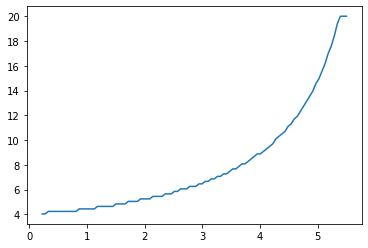

In [184]:
plt.plot(d_var, fit_tmax_d(d_var))

7.533257724940469 7.534774499050048


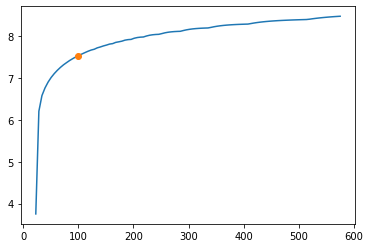

In [165]:
fit_Vmax_p = interpolate.InterpolatedUnivariateSpline(p_var, Vmax_arr[:,2])
plt.plot(p_var, Vmax_arr[:,2])
plt.plot(p, fit_Vmax_p(p),'o')
print(fit_Vmax_p(p), V_max)

In [151]:
de_tmax_d(100)

array(23143032.27588079)

#### Q5
You will use data in the files p1.csv  Download p1.csvand p2.csv  Download p2.csv to perform separate fits of the model parameters b, d, and p. I suggest using the scipy function least_squares. It's not as convenient as the curve_fit routine shown in the class example because it requires you to define the residual function that is used to calculate , but  you will need to write a function to compute  for this problem anyway. Perform fits of the data in both datasets and report the optimized values you find for the parameters and . Make separate plots of the residuals in each case and explain why you think the fit in each case is good or not.

In [4]:
df_p1 = pd.read_csv('p1.csv', sep=',', header=0,index_col=0)
df_p2 = pd.read_csv('p2.csv', sep=',', header=0,index_col=0)

In [95]:
df_p2

,time,log10_V
1,1.0,8.283016
2,2.0,7.606335
3,3.0,6.864064
4,4.0,6.357612
5,5.0,5.570422
6,6.0,5.004087
7,7.0,4.431227
8,8.0,3.665552
9,9.0,2.999995
10,10.0,2.404659


In [328]:
# Cost function definition
# b, d, p = 1e-7, 1, 100
def cost(data, b=1e-7, d=1, p=100, g=15):
    y_out = odeint(viral_kinetics_model, y0, data['time'], args=(b, d, p,))
    Vpred= np.log10(y_out[:,2])
    return sum((Vpred-data['log10_V'])**2)

## $\chi^2$ distributions for the Exact and Approximate models

Text(0.5, 1.0, 'Varying b')

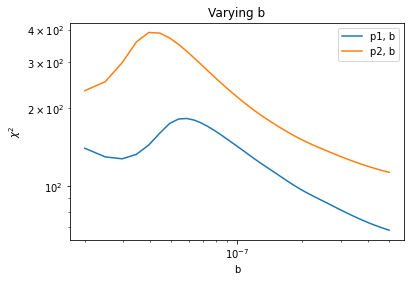

In [329]:
# vary b over the range 2e-8 to 5e-7
b_range = np.linspace(2e-8, 5e-7, 100)
# vary d over the range 0.26, 6.5
d_range = np.linspace(0.22, 0.22*25, 100)
# vary p over the range 10, 250
p_range = np.linspace(23, 23*25, 100)

cost_p1_arr = np.empty(shape=(100, 3))
cost_p2_arr = np.empty(shape=(100, 3))

cost_p1_b = [cost(data=df_p1, b=b_range[i]) for i in range(len(b_range))]
cost_p2_b = [cost(data=df_p2, b=b_range[i]) for i in range(len(b_range))]

plt.plot(b_range, cost_p1_b, label='p1, b')
plt.plot(b_range, cost_p2_b, label='p2, b')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('b')
plt.ylabel('$\chi^2$')
plt.legend(loc='best')
plt.title('Varying b')

In [35]:
# def cost(param, data_time, data_log10_V, y0=y0, t=t):
#     log10_b, d, p = param[0], param[1], param[2]
#     y_out = odeint(viral_kinetics_model_5, y0, t, args=(log10_b, d, p,))
#     V_pred = interpolate.interp1d(t, y_out[:,2], kind = 'cubic')(data_time)
#     log10_V_pred= np.log10(V_pred)
#     return sum((log10_V_pred-data_log10_V)**2)

# param = [0,0,0]

# cost(param, df_p1['time'], df_p1['log10_V'], y0=y0, t=t)

# from scipy.optimize import leastsq

# result = leastsq(cost, param, args=(df_p1['time'],df_p1['log10_V']))


# b_fit, d_fit, p_fit = result[0][0], result[0][1], result[0][2]

nan

In [20]:
!pip install lmfit

     |████████████████████████████████| 292 kB 9.9 MB/s 
     |████████████████████████████████| 40 kB 5.4 MB/s 
     |████████████████████████████████| 98 kB 6.6 MB/s 
  Created wheel for lmfit: filename=lmfit-1.0.3-py3-none-any.whl size=84402 sha256=62d9414514bbd51dcd1dc2326ad86021461d137c9811b9625dac2317ce24152f
  Stored in directory: /root/.cache/pip/wheels/b9/7a/d1/236aa0f8196b264fda481a112f7cfb1bfde7bfb20235f8e331
  Created wheel for asteval: filename=asteval-0.9.26-py3-none-any.whl size=17648 sha256=97bc2df7db8adb5a2348df420ff1ad11f7b89a249e76425a5f7289ef4d8da05b
  Stored in directory: /root/.cache/pip/wheels/4c/e9/f0/bc343d5b77d2fded45177f424a6b0b9224b92ff6e7c150bad4
Successfully built lmfit asteval


In [113]:
import lmfit

# For problems 5 and 6 you are strongly recommended to tranform your model 
# to use log10(b) as a parameter instead of b to avoid numerical errors and/or loss of precision.
def viral_kinetics_model_5(y, t, log10_b, d, p):
    S, I, V, g, b = y[0], y[1], y[2], 15, 10**log10_b
    # the differential equations that define the dynamics of the model
    dSdt = -b * S * V
    dVdt = p * I - b * S * V - g * V
    dIdt = b * S * V - d * I
    return [dSdt, dIdt, dVdt]

# Cost function definition
def cost(param, data_time, data_log10_V, y0=y0, t=t):
    log10_b, d, p = param['log10_b'].value, param['d'].value, param['p'].value
    y_out = odeint(viral_kinetics_model_5, y0, t, args=(log10_b, d, p,))
    V_pred = interpolate.interp1d(t, y_out[:,2], kind = 'cubic')(data_time)
    log10_V_pred = np.log10(V_pred)
    return (log10_V_pred-data_log10_V)**2
    #return (V_pred-10**data_log10_V)**2

# set parameters
param = lmfit.Parameters()
param.add('log10_b', value= -7, min=-10, max=10)
param.add('d', value= 1, min=0.1, max=100)
param.add('p', value= 100, min=10, max=1000)

In [114]:
# p1
p1_mini = lmfit.Minimizer(cost, param, fcn_args=(df_p1['time'], df_p1['log10_V']))
p1_fit = p1_mini.minimize(method='leastsq')

lmfit.report_fit(p1_fit)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 77
    # data points      = 10
    # variables        = 3
    chi-square         = 0.00775741
    reduced chi-square = 0.00110820
    Akaike info crit   = -65.6169151
    Bayesian info crit = -64.7091598
[[Variables]]
    log10_b: -6.54214800 +/- 0.06746603 (1.03%) (init = -7)
    d:        1.97396965 +/- 0.02851525 (1.44%) (init = 1)
    p:        118.096156 +/- 19.3265275 (16.37%) (init = 100)
[[Correlations]] (unreported correlations are < 0.100)
    C(log10_b, p) = -0.936
    C(log10_b, d) = -0.558
    C(d, p)       = 0.311


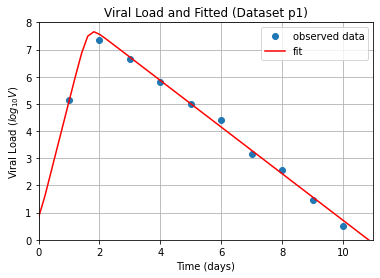

In [101]:
# plot fit and residuals
log10_b, d, p = -6.54214800, 1.97396965, 118.096156
y_out = odeint(viral_kinetics_model_5, y0, t, args=(log10_b, d, p,))
V_pred = interpolate.interp1d(t, y_out[:,2], kind = 'cubic')(t)
log10_V_pred= np.log10(V_pred)

plt.plot(df_p1['time'], df_p1['log10_V'], 'o', label="observed data")
plt.plot(t, log10_V_pred, color="red", label="fit")

plt.xlim(0,11)
plt.ylim(0,8)
plt.xlabel('Time (days)')
plt.ylabel('Viral Load ($log_{10}V$)')
plt.title('Viral Load and Fitted (Dataset p1)')
plt.legend()
plt.grid(True)
plt.show()

1.228528702162351


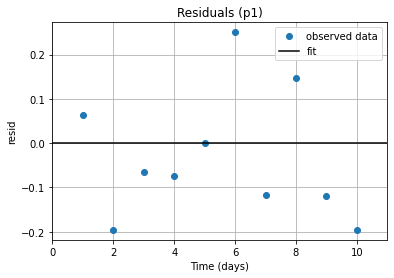

In [103]:
V_pred = interpolate.interp1d(t, y_out[:,2], kind = 'cubic')(df_p1['time'])
log10_V_pred= np.log10(V_pred)

residuals = df_p1['log10_V'] - log10_V_pred

print(sum(abs(residuals)))

plt.plot(df_p1['time'], residuals, 'o', label="observed data")
plt.plot(t, [0]*len(t), color="black", label="fit")

plt.xlim(0,11)
plt.xlabel('Time (days)')
plt.ylabel('resid')
plt.title('Residuals (p1)')
plt.legend()
plt.grid(True)
plt.show()

In [107]:
param_fit_p1 = [-6.54214800, 1.97396965, 118.096156]
costs = cost(param, df_p1['time'], df_p1['log10_V'], y0=y0, t=t)
print(sum(costs))

97.82284036629906


In [115]:
# p2
p2_mini = lmfit.Minimizer(cost, param, fcn_args=(df_p2['time'], df_p2['log10_V']))
p2_fit = p2_mini.minimize(method='leastsq')

lmfit.report_fit(p2_fit)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 69
    # data points      = 15
    # variables        = 3
    chi-square         = 0.01143879
    reduced chi-square = 9.5323e-04
    Akaike info crit   = -101.681924
    Bayesian info crit = -99.5577735
[[Variables]]
    log10_b: -6.53481719 +/- 0.10481743 (1.60%) (init = -7)
    d:        1.51678374 +/- 0.03026026 (2.00%) (init = 1)
    p:        262.995232 +/- 10.8899369 (4.14%) (init = 100)
[[Correlations]] (unreported correlations are < 0.100)
    C(log10_b, d) = -0.911
    C(d, p)       = 0.896
    C(log10_b, p) = -0.728


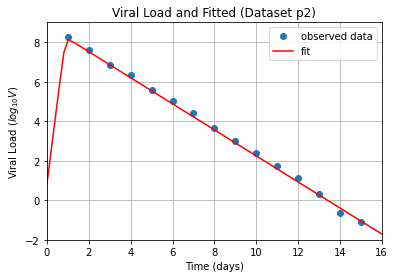

In [105]:
# plot fit and residuals
log10_b, d, p = -6.53481719, 1.51678374, 262.995232
y_out = odeint(viral_kinetics_model_5, y0, t, args=(log10_b, d, p,))
V_pred = interpolate.interp1d(t, y_out[:,2], kind = 'cubic')(t)
log10_V_pred= np.log10(V_pred)

plt.plot(df_p2['time'], df_p2['log10_V'], 'o', label="observed data")
plt.plot(t, log10_V_pred, color="red", label="fit")

plt.xlim(0,16)
plt.ylim(-2,9)
plt.xlabel('Time (days)')
plt.ylabel('Viral Load ($log_{10}V$)')
plt.title('Viral Load and Fitted (Dataset p2)')
plt.legend()
plt.grid(True)
plt.show()

1.8469982900671749


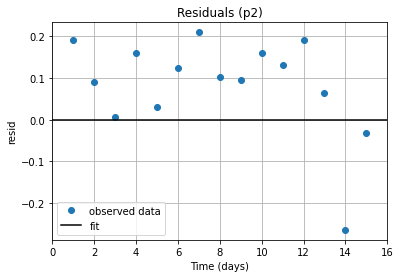

In [106]:
V_pred = interpolate.interp1d(t, y_out[:,2], kind = 'cubic')(df_p2['time'])
log10_V_pred= np.log10(V_pred)

residuals = df_p2['log10_V'] - log10_V_pred

print(sum(abs(residuals)))

plt.plot(df_p2['time'], residuals, 'o', label="observed data")
plt.plot(t, [0]*len(t), color="black", label="fit")

plt.xlim(0,16)
plt.xlabel('Time (days)')
plt.ylabel('resid')
plt.title('Residuals (p2)')
plt.legend()
plt.grid(True)
plt.show()

In [108]:
param_fit_p2 = [-6.53481719, 1.51678374, 262.995232]
costs = cost(param, df_p2['time'], df_p2['log10_V'], y0=y0, t=t)
print(sum(costs))

151.01164161943368


#### Q6

In [116]:
p1_ci = lmfit.conf_interval(p1_mini, p1_fit)
lmfit.printfuncs.report_ci(p1_ci)

            99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 log10_b:  -0.21944  -0.13683  -0.07081  -6.54215  +0.07058  +0.17740  +0.34612
 d      :  -0.13263  -0.07030  -0.02921   1.97397  +0.02919  +0.06584  +0.12461
 p      : -58.03570 -35.65044 -16.53850 118.09616 +23.54926 +45.42347 +77.73824


In [118]:
p2_ci = lmfit.conf_interval(p2_mini, p2_fit)
lmfit.printfuncs.report_ci(p2_ci)

/usr/local/lib/python3.7/dist-packages/lmfit/confidence.py:330: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(log10_b=-6.639634621145124) = 0.0 < max(sigmas)
  warn(errmsg)


            99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 log10_b:      -inf      -inf      -inf  -6.53482  +0.02684  +0.08798  +0.18577
 d      :  -0.03014  -0.01639  -0.00627   1.51678  +0.01872  +0.02308  +0.03344
 p      : -52.84786 -26.85861  -8.97950 262.99523      +inf      +inf      +inf


/usr/local/lib/python3.7/dist-packages/lmfit/confidence.py:330: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(p=273.88516906931864) = 0.0 < max(sigmas)
  warn(errmsg)
